## <center>Universidade do Estado do Amazonas</center>
##### <center>Pós-graduação Lato Sensu em Ciência de Dados</center>

<center>

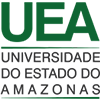

</center>

---

## <center>Código fonte do TCC: Análise dos dados 3º Trimestre de 2019</center>
##### <center>**Orientadora:** Msc. Alice Adativa</center>
###### <center>**Aluno:** Daniel Erasmo Leite Soares</center>



---



## <center>Fonte de dados.</center>

[DB Queimadas do INPE.](https://queimadas.dgi.inpe.br/queimadas/bdqueimadas)


## **Preparação do Ambiente**

---



In [1]:
# Pacotes instalados
!pip install geopandas
!pip install contextily
!pip install biokit
!pip install plotly

     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 16.7 MB 287 kB/s 
     |████████████████████████████████| 6.3 MB 42.0 MB/s 
     |████████████████████████████████| 19.3 MB 1.7 MB/s 
     |████████████████████████████████| 162 kB 5.3 MB/s 
     |████████████████████████████████| 47 kB 4.7 MB/s 
     |████████████████████████████████| 1.0 MB 53.4 MB/s 
     |████████████████████████████████| 2.3 MB 47.6 MB/s 
     |████████████████████████████████| 51 kB 223 kB/s 
     |████████████████████████████████| 47 kB 267 kB/s 
     |████████████████████████████████| 144 kB 50.2 MB/s 
     |████████████████████████████████| 5.8 MB 39.9 MB/s 
     |████████████████████████████████| 251 kB 59.1 MB/s 
     |████████████████████████████████| 127 kB 46.5 MB/s 
  Created wheel for biokit: filename=biokit-0.5.0-py3-none-any.whl size=177148 sha256=718997a670fe66dc07201278708f952721c97e990c95637b47c50a741fdc4199
  Stored in directory: /root/.cache/pip/wheel

In [2]:
## Bibliotecas de Tratamento de Dados
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import contextily
import numpy as np

## Bibliotecas Gráficas
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go

## Bibliotecas de ML
from sklearn.cluster import KMeans

## **Carregamento e preparação do DataFrame de todos os Biomas**

---



In [3]:
# Montando a pasta do Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Criando os DataFrames de alertas de focos de queimadas do Brasil
alertas = pd.read_csv('/content/drive/MyDrive/TCC/dataset/meses_focos_biomas_2019-01-01_2019-12-31.csv')

## **Preparação do DataFrame somente do Bioma Amazônia**

---



In [5]:
alertas_amazonia = alertas[alertas['bioma'] == 'Amazonia']

## **Preparação do DataFrame com dados do 3º trimestre 2019**

---



In [6]:
alertas_m07 = alertas_amazonia[alertas_amazonia['mes'] == 7]
alertas_m08 = alertas_amazonia[alertas_amazonia['mes'] == 8]
alertas_m09 = alertas_amazonia[alertas_amazonia['mes'] == 9]

alertas_todos = [alertas_m07, alertas_m08, alertas_m09]
alertas_trim03 = pd.concat(alertas_todos)

In [7]:
alertas_trim03

,mes,datahora,satelite,pais,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
221,7,2019/07/19 17:25:00,AQUA_M-T,Brasil,TOCANTINS,ARAPOEMA,Amazonia,10,0.0,0.9,-7.739,-48.840,48.4
222,7,2019/07/19 17:25:00,AQUA_M-T,Brasil,PARA,ALTAMIRA,Amazonia,39,0.0,0.8,-7.521,-54.990,19.9
223,7,2019/07/19 17:30:00,AQUA_M-T,Brasil,AMAZONAS,APUI,Amazonia,16,0.0,0.6,-7.266,-59.837,9.3
224,7,2019/07/19 17:30:00,AQUA_M-T,Brasil,AMAZONAS,APUI,Amazonia,17,0.0,0.9,-7.265,-59.827,11.0
225,7,2019/07/19 17:30:00,AQUA_M-T,Brasil,AMAZONAS,APUI,Amazonia,26,0.7,0.5,-7.191,-59.641,77.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197396,9,2019/09/28 17:35:00,AQUA_M-T,Brasil,MATO GROSSO,COLNIZA,Amazonia,2,7.2,0.6,-9.297,-59.089,11.3
197397,9,2019/09/28 17:35:00,AQUA_M-T,Brasil,MATO GROSSO,COLNIZA,Amazonia,2,0.4,0.3,-9.283,-59.441,11.8
197398,9,2019/09/28 17:35:00,AQUA_M-T,Brasil,AMAZONAS,BOCA DO ACRE,Amazonia,0,2.0,0.1,-9.252,-67.884,577.2
197399,9,2019/09/28 17:35:00,AQUA_M-T,Brasil,AMAZONAS,BOCA DO ACRE,Amazonia,0,2.5,0.1,-9.248,-67.910,171.3


## **Criação o GeoDataFrame e Sistema de Referência de Coordenadas**

---



In [8]:
geometry = [Point(xy) for xy in zip(alertas_trim03['longitude'], alertas_trim03['latitude'])]

In [9]:
alertas_trim03 = gpd.GeoDataFrame(alertas_trim03, crs='EPSG:4326', geometry=geometry)

In [10]:
type(alertas_trim03)

geopandas.geodataframe.GeoDataFrame

In [11]:
alertas_trim03

,mes,datahora,satelite,pais,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp,geometry
221,7,2019/07/19 17:25:00,AQUA_M-T,Brasil,TOCANTINS,ARAPOEMA,Amazonia,10,0.0,0.9,-7.739,-48.840,48.4,POINT (-48.84000 -7.73900)
222,7,2019/07/19 17:25:00,AQUA_M-T,Brasil,PARA,ALTAMIRA,Amazonia,39,0.0,0.8,-7.521,-54.990,19.9,POINT (-54.99000 -7.52100)
223,7,2019/07/19 17:30:00,AQUA_M-T,Brasil,AMAZONAS,APUI,Amazonia,16,0.0,0.6,-7.266,-59.837,9.3,POINT (-59.83700 -7.26600)
224,7,2019/07/19 17:30:00,AQUA_M-T,Brasil,AMAZONAS,APUI,Amazonia,17,0.0,0.9,-7.265,-59.827,11.0,POINT (-59.82700 -7.26500)
225,7,2019/07/19 17:30:00,AQUA_M-T,Brasil,AMAZONAS,APUI,Amazonia,26,0.7,0.5,-7.191,-59.641,77.9,POINT (-59.64100 -7.19100)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197396,9,2019/09/28 17:35:00,AQUA_M-T,Brasil,MATO GROSSO,COLNIZA,Amazonia,2,7.2,0.6,-9.297,-59.089,11.3,POINT (-59.08900 -9.29700)
197397,9,2019/09/28 17:35:00,AQUA_M-T,Brasil,MATO GROSSO,COLNIZA,Amazonia,2,0.4,0.3,-9.283,-59.441,11.8,POINT (-59.44100 -9.28300)
197398,9,2019/09/28 17:35:00,AQUA_M-T,Brasil,AMAZONAS,BOCA DO ACRE,Amazonia,0,2.0,0.1,-9.252,-67.884,577.2,POINT (-67.88400 -9.25200)
197399,9,2019/09/28 17:35:00,AQUA_M-T,Brasil,AMAZONAS,BOCA DO ACRE,Amazonia,0,2.5,0.1,-9.248,-67.910,171.3,POINT (-67.91000 -9.24800)


In [12]:
alertas_trim03 = alertas_trim03.to_crs(crs='EPSG:3857')

In [13]:
alertas_trim03.crs.to_string()

'EPSG:3857'

## **Geração dos gráficos de quantitativos e localização dos focos por Estado**

In [14]:
alertas_trim03['estado'].unique()

array(['TOCANTINS', 'PARA', 'AMAZONAS', 'MATO GROSSO', 'MARANHAO', 'ACRE',
       'RONDONIA', 'RORAIMA', 'AMAPA'], dtype=object)

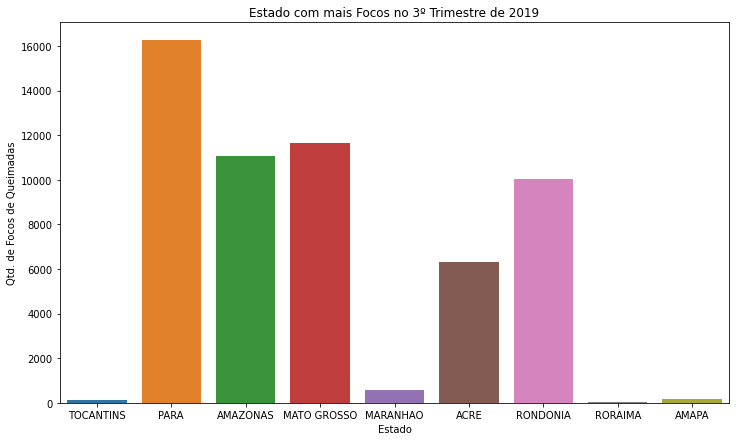

In [15]:
plt.figure(figsize=(12,7))
ax = sns.countplot(x='estado', data=alertas_trim03)
ax.set_title("Estado com mais Focos no 3º Trimestre de 2019")
ax.set_xlabel('Estado')
ax.set_ylabel('Qtd. de Focos de Queimadas')
plt.show()

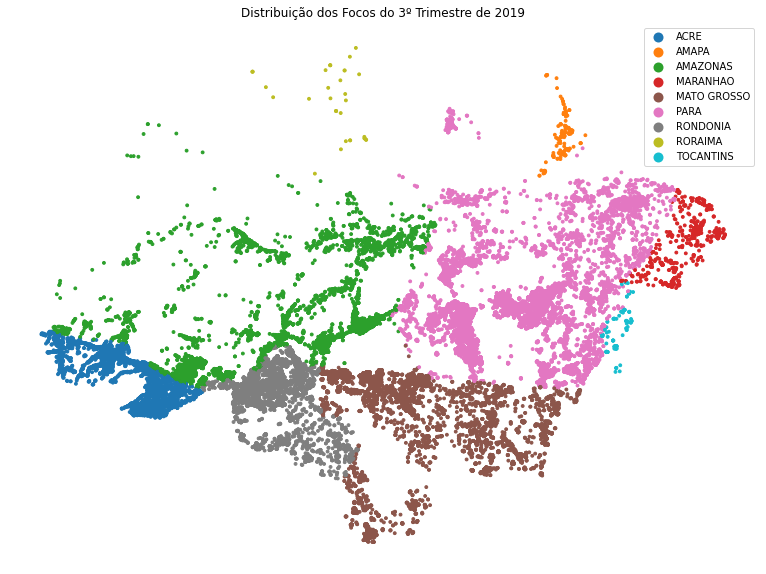

In [26]:
ax = alertas_trim03.plot(figsize=(15, 10), column='estado', markersize=8, legend=True)
#contextily.add_basemap(ax)
ax.set_axis_off()
ax.set_title("Distribuição dos Focos do 3º Trimestre de 2019")
plt.show()

## **Aplicação dos Algoritmo K-Means**


*   K-Means

**K-Means Para o Bioma Amazônia**

In [17]:
coord_amazonia = alertas_trim03.drop(columns=["datahora","satelite","pais","estado","municipio","bioma","diasemchuva","precipitacao","riscofogo","frp","geometry"])

In [18]:
coord_amazonia

,mes,latitude,longitude
221,7,-7.739,-48.840
222,7,-7.521,-54.990
223,7,-7.266,-59.837
224,7,-7.265,-59.827
225,7,-7.191,-59.641
...,...,...,...
197396,9,-9.297,-59.089
197397,9,-9.283,-59.441
197398,9,-9.252,-67.884
197399,9,-9.248,-67.910


In [19]:
agrupadorK = KMeans(n_clusters=9)

In [20]:
agrupadorK.fit(coord_amazonia)

KMeans(n_clusters=9)

In [21]:
np.unique(agrupadorK.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

In [22]:
coord_amazonia['Grupo'] = agrupadorK.labels_

In [23]:
coord_amazonia

,mes,latitude,longitude,Grupo
221,7,-7.739,-48.840,0
222,7,-7.521,-54.990,3
223,7,-7.266,-59.837,2
224,7,-7.265,-59.827,2
225,7,-7.191,-59.641,2
...,...,...,...,...
197396,9,-9.297,-59.089,7
197397,9,-9.283,-59.441,7
197398,9,-9.252,-67.884,1
197399,9,-9.248,-67.910,1


**Gráfico com agrupamento por Cluster**

In [24]:
from seaborn.utils import locator_to_legend_entries
c0lat = coord_amazonia[coord_amazonia['Grupo']==0]['latitude']
c0lon = coord_amazonia[coord_amazonia['Grupo']==0]['longitude']
c1lat = coord_amazonia[coord_amazonia['Grupo']==1]['latitude']
c1lon = coord_amazonia[coord_amazonia['Grupo']==1]['longitude']
c2lat = coord_amazonia[coord_amazonia['Grupo']==2]['latitude']
c2lon = coord_amazonia[coord_amazonia['Grupo']==2]['longitude']
c3lat = coord_amazonia[coord_amazonia['Grupo']==3]['latitude']
c3lon = coord_amazonia[coord_amazonia['Grupo']==3]['longitude']
c4lat = coord_amazonia[coord_amazonia['Grupo']==4]['latitude']
c4lon = coord_amazonia[coord_amazonia['Grupo']==4]['longitude']
c5lat = coord_amazonia[coord_amazonia['Grupo']==5]['latitude']
c5lon = coord_amazonia[coord_amazonia['Grupo']==5]['longitude']
c6lat = coord_amazonia[coord_amazonia['Grupo']==6]['latitude']
c6lon = coord_amazonia[coord_amazonia['Grupo']==6]['longitude']
c7lat = coord_amazonia[coord_amazonia['Grupo']==7]['latitude']
c7lon = coord_amazonia[coord_amazonia['Grupo']==7]['longitude']
c8lat = coord_amazonia[coord_amazonia['Grupo']==8]['latitude']
c8lon = coord_amazonia[coord_amazonia['Grupo']==8]['longitude']

x0 = c0lat 
y0 = c0lon
x1 = c1lat
y1 = c1lon
x2 = c2lat
y2 = c2lon
x3 = c3lat
y3 = c3lon
x4 = c4lat
y4 = c4lon
x5 = c5lat
y5 = c5lon
x6 = c6lat
y6 = c6lon
x7 = c7lat
y7 = c7lon
x8 = c8lat
y8 = c8lon

# Create figure
fig = go.Figure()

# Add traces
fig.add_trace(
    go.Scatter(
        x=x0,
        y=y0,
        mode="markers",
        marker=dict(color="paleturquoise")
    )
)

fig.add_trace(
    go.Scatter(
        x=x1,
        y=y1,
        mode="markers",
        marker=dict(color="limegreen")
    )
)

fig.add_trace(
    go.Scatter(
        x=x2,
        y=y2,
        mode="markers",
        marker=dict(color="tomato")
    )
)

fig.add_trace(
    go.Scatter(
        x=x3,
        y=y3,
        mode="markers",
        marker=dict(color="dodgerblue")
    )
)

fig.add_trace(
    go.Scatter(
        x=x4,
        y=y4,
        mode="markers",
        marker=dict(color="rebeccapurple")
    )
)

fig.add_trace(
    go.Scatter(
        x=x5,
        y=y5,
        mode="markers",
        marker=dict(color="yellow")
    )
)

fig.add_trace(
    go.Scatter(
        x=x6,
        y=y6,
        mode="markers",
        marker=dict(color="chartreuse")
    )
)

fig.add_trace(
    go.Scatter(
        x=x7,
        y=y7,
        mode="markers",
        marker=dict(color="chocolate")
    )
)

fig.add_trace(
    go.Scatter(
        x=x8,
        y=y8,
        mode="markers",
        marker=dict(color="red")
    )
)


# Add buttons that add shapes
cluster0 = [dict(type="circle",
                            xref="x", yref="y",
                            x0=min(x0), y0=min(y0),
                            x1=max(x0), y1=max(y0),
                            line=dict(color="paleturquoise"))]
cluster1 = [dict(type="circle",
                            xref="x", yref="y",
                            x0=min(x1), y0=min(y1),
                            x1=max(x1), y1=max(y1),
                            line=dict(color="limegreen"))]
cluster2 = [dict(type="circle",
                            xref="x", yref="y",
                            x0=min(x2), y0=min(y2),
                            x1=max(x2), y1=max(y2),
                            line=dict(color="tomato"))]
cluster3 = [dict(type="circle",
                            xref="x", yref="y",
                            x0=min(x3), y0=min(y3),
                            x1=max(x3), y1=max(y3),
                            line=dict(color="dodgerblue"))]
cluster4 = [dict(type="circle",
                            xref="x", yref="y",
                            x0=min(x4), y0=min(y4),
                            x1=max(x4), y1=max(y4),
                            line=dict(color="rebeccapurple"))]
cluster5 = [dict(type="circle",
                            xref="x", yref="y",
                            x0=min(x5), y0=min(y5),
                            x1=max(x5), y1=max(y5),
                            line=dict(color="yellow"))]
cluster6 = [dict(type="circle",
                            xref="x", yref="y",
                            x0=min(x6), y0=min(y6),
                            x1=max(x6), y1=max(y6),
                            line=dict(color="chartreuse"))]
cluster7 = [dict(type="circle",
                            xref="x", yref="y",
                            x0=min(x7), y0=min(y7),
                            x1=max(x7), y1=max(y7),
                            line=dict(color="chocolate"))]
cluster8 = [dict(type="circle",
                            xref="x", yref="y",
                            x0=min(x8), y0=min(y8),
                            x1=max(x8), y1=max(y8),
                            line=dict(color="red"))]
fig.update_layout(
    updatemenus=[
        dict(buttons=list([
            dict(label="None",
                 method="relayout",
                 args=["shapes", []]),
            dict(label="Cluster 0",
                 method="relayout",
                 args=["shapes", cluster0]),
            dict(label="Cluster 1",
                 method="relayout",
                 args=["shapes", cluster1]),
            dict(label="Cluster 2",
                 method="relayout",
                 args=["shapes", cluster2]),
            dict(label="Cluster 3",
                 method="relayout",
                 args=["shapes", cluster3]),
            dict(label="Cluster 4",
                 method="relayout",
                 args=["shapes", cluster4]),
            dict(label="Cluster 5",
                 method="relayout",
                 args=["shapes", cluster5]),
            dict(label="Cluster 6",
                 method="relayout",
                 args=["shapes", cluster6]),
            dict(label="Cluster 7",
                 method="relayout",
                 args=["shapes", cluster7]),
            dict(label="Cluster 8",
                 method="relayout",
                 args=["shapes", cluster8]),
            dict(label="All",
                 method="relayout",
                 args=["shapes", cluster0 + cluster1 + cluster2 + cluster3 + cluster4 + cluster5 + cluster6 + cluster7 + cluster8])
        ]),
        )
    ]
)

# Update remaining layout properties
fig.update_layout(
    title_text="Clusters do 3º Trimestre de 2019",
    showlegend=False,
)
fig.show()
